### Máster en Ciencia de Datos - CUNEF

### Trabajo Final de Máster

### Detección de transacciones fraudulentas con tarjetas bancarias usando técnicas de clasificación

Alba Rodríguez Berenguel

En este último notebook se va a realizar la explicabilidad del modelo seleccionado. Para ello, se empleará la librería SHAP que permite realizar distintas visualizaciones para comprender mejor el funcionamiento.

1. Importación de librerías, funciones y datos.
2. Explicabilidad con SHAP.

## 1. Importación de librerías, funciones y datos

In [4]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from xgboost import XGBClassifier
import shap
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load data.
X_train_rfe = pd.read_parquet("../data/processed/X_train_rfe.parquet")
y_train = pd.read_parquet("../data/processed/y_train.parquet")['isfraud']
y_train = y_train.reset_index(drop=True)

X_test_rfe = pd.read_parquet("../data/processed/X_test_rfe.parquet")
y_test = pd.read_parquet("../data/processed/y_test.parquet")['isfraud']
y_test = y_test.reset_index(drop=True)

In [6]:
with open('../models/xgboost_optimizado.pickle', 'rb') as f:
    xgb = pickle.load(f)

## 2. Explicabilidad con SHAP

In [7]:
model = xgb.best_estimator_.named_steps['classifier']

explainer = shap.TreeExplainer(model)

In [8]:
shap_values = explainer.shap_values(X_test_rfe)

### 2.1. Summary plot

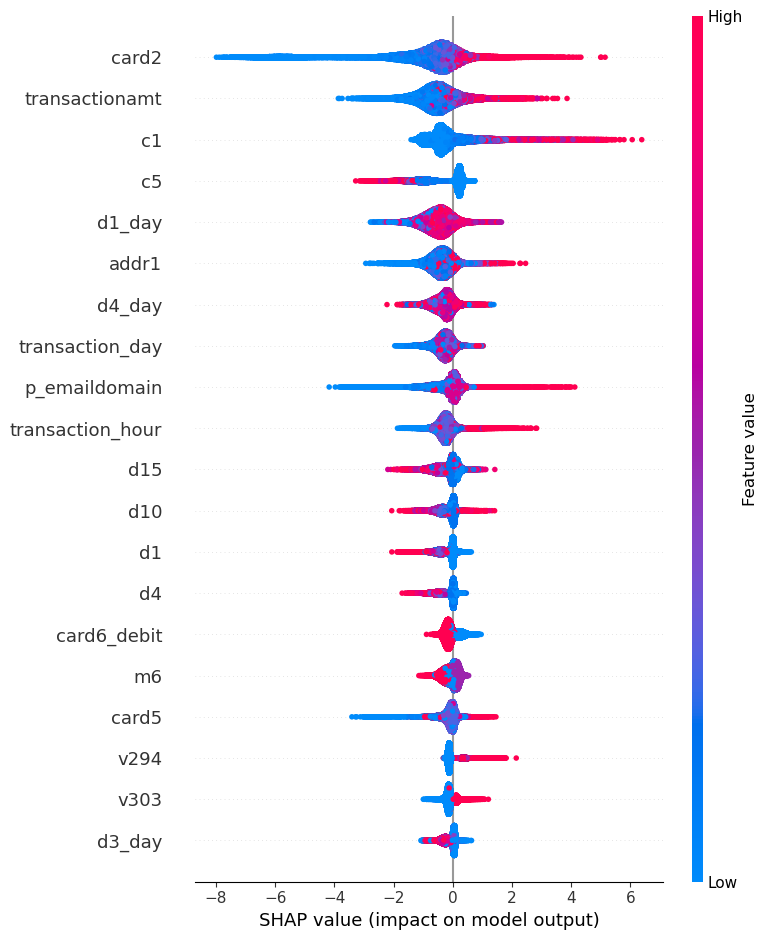

In [9]:
shap.summary_plot(shap_values, X_test_rfe)

Los valores altos contribuyen a aumentar la predicción de fraude en la mayoría de las variables. 

La primera que encontramos es card2 que tiene un rango de impacto bastante elevado, ocupando casi todo el eje y, como se ha mencionado, sus valores altos incrementan la predicción. Las siguientes variables que tenemos son transactionamt y c1, tienen el mismo comportamiento, transacciones de cuantías altas tienen más probabilidad de ser fraude. 

También, algunas de las variables que aparecen son las que se construyeron en el apartado de ingeniería de características (d1_day, d4_day y d3_day), por lo que se puede decir que se ha conseguido enriquecer el dataset, ya que tienen una importancia significativa.

### 2.1. Gráficos de fuerza

#### Fraude

In [10]:
fraud_index = y_test[y_test == 1].index[0]
not_fraud_index = y_test[y_test == 0].index[0]

# Asegurarse de que se usa el índice correcto para X_test_rfe
fraud_index_X = X_test_rfe.index.get_loc(fraud_index)
not_fraud_index_X = X_test_rfe.index.get_loc(not_fraud_index)

shap.force_plot(explainer.expected_value, shap_values[fraud_index_X, :], X_test_rfe.loc[fraud_index, :])

Esta primera figura refleja el cálculo de la predicción de un caso de fraude. Las variables que han contribuido a esta decisión son el día que se creó la tarjeta (d1_day) y otras variables como card2, v320, v307, etc., de las que no se conoce su significado. Por el contrario, algunas características que disminuyen su riesgo de transacción fraudulenta son la hora a la que se realizó y el día.

#### No fraude

In [11]:
shap.force_plot(explainer.expected_value, shap_values[not_fraud_index_X, :], X_test_rfe.loc[not_fraud_index, :])

Se aprecia que el valor SHAP es mucho más bajo que el anterior, de ahí que no sea fraude, ya que los valores más elevados son de transacciones fraudulentas. Algunas de las variables que ayudan a la predicción son m6 y v62, aunque no se observan en la figura. Las variables que están en azul, pero con un valor negativo, también aportan al no fraude, como es el caso de la cantidad transferida o el día.

### 2.2. Gráfico de dependencia 

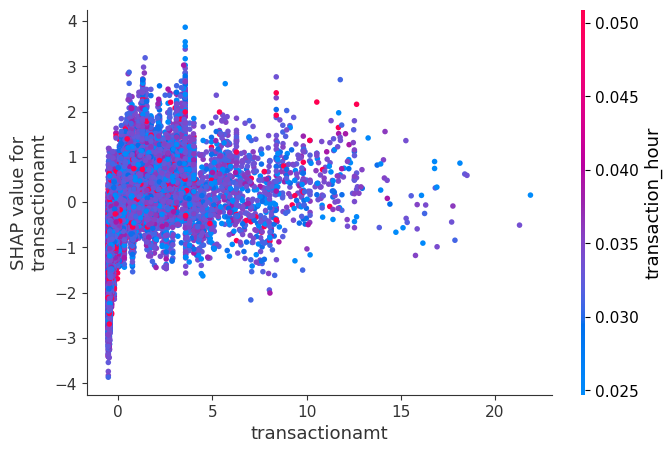

In [20]:
shap.dependence_plot("transactionamt", shap_values, X_test_rfe, interaction_index="transaction_hour")

Para la interpretación de este gráfico se debe tener en cuenta que cada punto del gráfico es una transacción, el eje X representa la cantidad que se ha transferido y el eje Y el valor SHAP. Además, el color de los puntos indica la hora de la transacción, el azul refleja las primeras horas y el rojo las últimas. 

Se observa una tendencia ascendente, lo que sugiere que las cantidades elevadas se asocian con una mayor probabilidad de fraude. En cuanto a las horas, se refleja una preponderancia de puntos azules, lo que indica que la mayoría de las transacciones se realizan en las primeras horas, independientemente de si son o no fraudulentas. 

También, se observa cierta dispersión, ya que hay transacciones de importes y hora similares pero con un valor SHAP muy distinto, por lo que debe haber otras características que influyen en esas predicciones.